<a href="https://colab.research.google.com/github/lariskelmer/TinyML/blob/main/Task3/YourFirstTransferLearning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - How to Use Pre-Trained Models and Transfer Learning

**Deep convolutional neural network models may take days or even weeks** to train on very large datasets. A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems. In this lesson, you
will discover how to use transfer learning when developing convolutional neural networks for computer vision applications. After reading this notebook, you will know:

- Transfer learning involves using models trained on one problem as a starting point on a related problem.
- Transfer learning is flexible, allowing the use of pre-trained models directly, as feature extraction preprocessing, and integrated into entirely new models.
- Keras provides convenient access to many top performing models on the ImageNet image recognition tasks such as VGG, Inception, and ResNet.

## 1.1 What is Transfer Learning?

**Transfer learning** generally refers to a process where a **model trained on one problem is used in some way on a second**, related problem. In deep learning, transfer learning is a technique whereby a neural network model is first trained on a problem similar to the problem that is being solved. One or more layers from the trained model are then used in a new model trained on the problem of interest.

> This is typically understood in a supervised learning context, where the input is the same but the target may be of a different nature. For example, we may learn about one set of visual categories, such as cats and dogs, in the first setting, then learn about a different set of visual categories, such as ants and wasps, in the second setting.

Transfer learning has the **benefit of decreasing the training time** for a neural network model and can result in lower generalization error. The weights in re-used layers may be used as the starting point for the training process and adapted in response to the new problem. This usage treats transfer learning as a type of weight initialization scheme. This may be useful when the first related problem has a lot more labeled data than the problem of interest and the similarity in the structure of the problem may be useful in both contexts.

## 1.2 How to Use Pre-Trained Models



A range of high-performing models have been developed for image classification and demonstrated on the annual ImageNet Large Scale Visual Recognition Challenge, or ILSVRC. This challenge, often referred to simply as ImageNet, given the source of the image used in the competition, has resulted in a number of innovations in the architecture and training of convolutional neural networks. In addition, many of the models used in the competitions have been released under
a permissive license. These models can be used as the basis for transfer learning in computer vision applications. This is desirable for a number of reasons, not least:

- **Useful Learned Features**: The models have learned how to detect generic features from photographs, given that they were trained on more than 1,000,000 images for 1,000
categories.
- **State-of-the-Art Performance**: The models achieved state-of-the-art performance and remain effective on the specific image recognition task for which they were developed.
- **Easily Accessible**: The model weights are provided as free downloadable files and many libraries provide convenient APIs to download and use the models directly.

The model weights can be downloaded and used in the same model architecture using a range of different deep learning libraries, including Keras.


**The use of a pre-trained model is limited only by your creativity**. For example, a model may be downloaded and used as-is, such as embedded into an application and used to classify new photographs. Alternately, models may be downloaded and used as feature extraction models. Here, the output of the model from a layer prior to the output layer of the model is used as input to a new classifier model. Recall that convolutional layers closer to the input layer of the model learn low-level features such as lines, that layers in the middle of the layer learn complex abstract features that combine the lower level features extracted from the input, and layers closer to the output interpret the extracted features in the context of a classification task.

Armed with this understanding, a level of detail for feature extraction from an existing pre-trained model can be chosen. For example, if a new task is quite different from classifying objects in photographs (e.g. different to ImageNet), then perhaps the output of the pre-trained
model after the first few layers would be appropriate. If a new task is quite similar to the task of classifying objects in photographs, then perhaps the output from layers much deeper in the model can be used, or even the output of the fully connected layer prior to the output layer can be used.

The pre-trained model can be used as a separate feature extraction program, in which case input can be pre-processed by the model or portion of the model to a given an output (e.g. vector of numbers) for each input image, that can then used as input when training a new model. Alternately, the pre-trained model or desired portion of the model can be integrated directly into a new neural network model. In this usage, the weights of the pre-trained can be frozen so that they are not updated as the new model is trained. Alternately, the weights may be updated during the training of the new model, perhaps with a lower learning rate, allowing the pre-trained model to act like a weight initialization scheme when training the new model. We can summarize some of these usage patterns as follows:

- **Classifier**: The pre-trained model is used directly to classify new images.
- **Standalone Feature Extractor**: The pre-trained model, or some portion of the model, is used to pre-process images and extract relevant features.
- **Integrated Feature Extractor**: The pre-trained model, or some portion of the model, is integrated into a new model, but layers of the pre-trained model are frozen during
training.
- **Weight Initialization**: The pre-trained model, or some portion of the model, is integrated into a new model, and the layers of the pre-trained model are trained in concert with the new model.

Each approach can be effective and save significant time in developing and training a deep convolutional neural network model. It may not be clear as to which usage of the pre-
trained model may yield the best results on your new computer vision task, therefore **some experimentation may be required**.


# 2 - Extracting features with a pre-trained CNN

Up until this point, we have treated Convolutional Neural Networks as end-to-end image classifiers:

1. We input an image to the network.
2. The image forward propagates through the network.
3. We obtain the final classification probabilities from the end of the network.

However, **there is no “rule” that says we must allow the image to forward propagate through
the entire network**. 

> Instead, we can stop the propagation at an arbitrary layer, such as an activation
or pooling layer, extract the values from the network at this time, and then use them as feature
vectors. 

For example, let’s consider the VGG16 network architecture by [Simonyan and Zisserman](https://arxiv.org/abs/1409.1556) (Figure below, left).

<center><img width="500" src="https://drive.google.com/uc?export=view&id=1CNy_EpEVeVAn7LJbPyeZm7xKW1rLnwdz"></center><center><b>Left</b>: The original VGG16 network architecture that outputs probabilities for each of the 1,000 ImageNet class labels. <b>Right</b>: Removing the FC layers from VGG16 and instead returning the output of the final POOL layer. This output will serve as our extracted features.</center>

Along with the layers in the network, we have also included the input and output shapes of the
volumes for each layer. When treating networks as a feature extractor, we essentially “chop off” the network at an arbitrary point (normally prior to the fully-connected layers, but it really depends on your particular dataset).

Now the last layer in our network is a max pooling layer (Figure above, right) which will have the output shape of 7 x 7 x 512 implying there are 512 filters each of size 7 x 7. If we were to forward propagate an image through this network with its FC head removed, we would be left with 512, 7x7 activations that have either activated or not based on the image contents. Therefore, we can actually take these 7x7x512 = 25,088 values and treat them as a feature vector that **quantifies the contents of an image**.

If we repeat this process for an entire dataset of images (including datasets that VGG16 was
not trained on), we’ll be left with a design matrix of N images, each with 25,088 columns used to
quantify their contents (i.e., feature vectors). Given our feature vectors, we can train an off-the-shelf machine learning model such a **Linear SVM, Logistic Regression classifier, or Random Forest** on top of these features to obtain a classifier that recognizes new classes of images.

Keep in mind that the CNN itself is not capable of recognizing these new classes – instead,
we are using the CNN as an intermediary feature extractor. The downstream machine learning
classifier will take care of learning the underlying patterns of the features extracted from the CNN.


## 2.1 Install and Import Dependencies

In [ ]:
# install wandb
!pip install wandb -qU
!pip install codecarbon

     |████████████████████████████████| 1.9 MB 27.7 MB/s 
     |████████████████████████████████| 182 kB 49.3 MB/s 
     |████████████████████████████████| 168 kB 40.0 MB/s 
     |████████████████████████████████| 62 kB 915 kB/s 
     |████████████████████████████████| 168 kB 76.4 MB/s 
     |████████████████████████████████| 166 kB 80.0 MB/s 
     |████████████████████████████████| 166 kB 82.1 MB/s 
     |████████████████████████████████| 162 kB 78.4 MB/s 
     |████████████████████████████████| 162 kB 75.4 MB/s 
     |████████████████████████████████| 158 kB 80.9 MB/s 
     |████████████████████████████████| 157 kB 73.7 MB/s 
     |████████████████████████████████| 157 kB 80.7 MB/s 
     |████████████████████████████████| 157 kB 71.8 MB/s 
     |████████████████████████████████| 157 kB 78.5 MB/s 
     |████████████████████████████████| 157 kB 76.3 MB/s 
     |████████████████████████████████| 157 kB 74.0 MB/s 
     |████████████████████████████████| 157 kB 76.5 MB/s 
     |██████████

In [ ]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
import wandb
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
wandb.login()
key = 'e64bf25e5e0a6d2a2c5c43c671774d5edec0759f'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import os
#os.environ['KAGGLE_USERNAME'] = "lariskelmer"
#os.environ['KAGGLE_KEY'] = "5a7e9704e30c3b1b73607ecacd9dfc6f"

#from kaggle.api.kaggle_api_extended import KaggleApi
#api = KaggleApi()
#api.authenticate()

In [ ]:
#api.dataset_download_files('deepcontractor/is-that-santa-image-classification', path=".")
#!mv "/content/is-that-santa-image-classification.zip" "/content/drive/MyDrive/UFRN/Graduacao/2022/IA_Embarcada/TF/data"

#### Download the code zip file

In [ ]:
!unzip /content/drive/MyDrive/UFRN/Graduacao/2022/IA_Embarcada/TF/data/is-that-santa-alter.zip

Archive:  /content/drive/MyDrive/UFRN/Graduacao/2022/IA_Embarcada/TF/data/is-that-santa-alter.zip
   creating: is-that-santa-alter/not-a-santa/
  inflating: is-that-santa-alter/not-a-santa/0.not-a-santa.jpg  
  inflating: is-that-santa-alter/not-a-santa/1.not-a-santa.jpg  
  inflating: is-that-santa-alter/not-a-santa/10.not-a-santa.jpg  
  inflating: is-that-santa-alter/not-a-santa/100.not-a-santa.jpg  
  inflating: is-that-santa-alter/not-a-santa/101.not-a-santa.jpg  
  inflating: is-that-santa-alter/not-a-santa/102.not-a-santa.jpg  
  inflating: is-that-santa-alter/not-a-santa/103.not-a-santa.jpg  
  inflating: is-that-santa-alter/not-a-santa/104.not-a-santa.jpg  
  inflating: is-that-santa-alter/not-a-santa/105.not-a-santa.jpg  
  inflating: is-that-santa-alter/not-a-santa/106.not-a-santa.jpg  
  inflating: is-that-santa-alter/not-a-santa/107.not-a-santa.jpg  
  inflating: is-that-santa-alter/not-a-santa/108.not-a-santa.jpg  
  inflating: is-that-santa-alter/not-a-santa/109.not-a-sa

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

### Step 02: Upload raw data

In [ ]:
"""
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "dataset": "is-that-santa-alter",
  "project_name": "first_transfer_learner_KNN",
  "artifact_name": "is-that-santa-alter", #:latest",
}
"""

'\n# since we are using Jupyter Notebooks we can replace our argument\n# parsing code with *hard coded* arguments and values\nargs = {\n  "dataset": "is-that-santa-alter",\n  "project_name": "first_transfer_learner_KNN",\n  "artifact_name": "is-that-santa-alter", #:latest",\n}\n'

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "dataset": "is-that-santa-alter",
  "project_name": "first_transfer_learner_VGG16",
  "artifact_name": "is-that-santa-alter", #:latest",
}

####First run with that dataset?

######If yes:


In [ ]:
#"""
# open the W&B project created in the Fetch step
run = wandb.init(entity="larissakelmer",project=args["project_name"], job_type="fetching_data-segregation")

# download the raw data from W&B
raw_data = wandb.Artifact(args["artifact_name"], type="raw_data")

# grab the list of images that we'll be describing
logger.info("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))

# append all images to the artifact
for img in imagePaths:
  "animals/dogs/dogs_0001.jpg > dogs/dogs_0001.jpg"
  label = img.split(os.path.sep)
  raw_data.add_file(img, name=os.path.join(label[-2],label[-1]))

# save artifact to W&B
run.log_artifact(raw_data)
run.finish()
#"""

wandb: Currently logged in as: larissakelmer. Use `wandb login --relogin` to force relogin


02-12-2022 23:10:27 [INFO] loading images...


######If not:

In [ ]:
"""
# open the W&B project created in the Fetch step
run = wandb.init(entity="larissakelmer",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))
run.finish()
"""

'\n# open the W&B project created in the Fetch step\nrun = wandb.init(entity="larissakelmer",project=args["project_name"], job_type="preprocessing")\n\n# download the raw data from W&B\nraw_data = run.use_artifact(args["artifact_name"])\ndata_dir = raw_data.download()\nlogger.info("Path: {}".format(data_dir))\nrun.finish()\n'

## Preprocessing

### Step 01: EDA

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

In [ ]:
"""
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "dataset": "is-that-santa-alter",
  "project_name": "first_transfer_learner_KNN",
  "artifact_name": "is-that-santa-alter:latest",
  "eda_name": "eda_santa"
}
"""

'\n# since we are using Jupyter Notebooks we can replace our argument\n# parsing code with *hard coded* arguments and values\nargs = {\n  "dataset": "is-that-santa-alter",\n  "project_name": "first_transfer_learner_KNN",\n  "artifact_name": "is-that-santa-alter:latest",\n  "eda_name": "eda_santa"\n}\n'

In [ ]:
args = {
  "dataset": "is-that-santa-alter",
  "project_name": "first_transfer_learner_VGG16",
  "artifact_name": "is-that-santa-alter:latest",
  "eda_name": "eda_santa"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="larissakelmer",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

# save artifact to W&B
run.finish()

Problem at: <ipython-input-42-fbf5fdbc6d5a> 2 <module>


UsageError: ignored

In [ ]:
# create a table with columns we want to track/compare
preview_dt = wandb.Table(columns=["id", "image", "label","size"])

# create a new artifact to store the EDA data
eda_data = wandb.Artifact(args["eda_name"], type="eda_data")

In [ ]:
# grab the list of images that we'll be describing
imagePaths = list(paths.list_images(data_dir))

# append all images to the artifact
for img in imagePaths:
  "img example: ./artifacts/animals_raw_data:v0/dogs/dogs_00892.jpg"
  label = img.split(os.path.sep)
  image = cv2.imread(img)
  preview_dt.add_data(label[-1], wandb.Image(img), label[-2], str(image.shape[0]) + " X " + str(image.shape[1]))

In [ ]:
# save artifact to W&B
eda_data.add(preview_dt, "EDA_Table")
run.log_artifact(eda_data)

###Step 03 - Clean Data

In [ ]:
"""
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "dataset": "clean_data",
  "label": "label",
  "project_name": "first_transfer_learner_KNN",
  "artifact_name": "is-that-santa-alter:latest",
}
"""

In [ ]:
args = {
  "dataset": "clean_data",
  "label": "label",
  "project_name": "first_transfer_learner_VGG16",
  "artifact_name": "is-that-santa-alter:latest",
}

In [ ]:
# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

In [ ]:
# a basic simple preprocessor
class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect
		# ratio
		return cv2.resize(image, (self.width, self.height),interpolation=self.inter)

In [ ]:
# Building an image loader
class SimpleDatasetLoader:
  def __init__(self, preprocessors=None, logger=None):
		# store the image preprocessor
    self.preprocessors = preprocessors
    self.logger = logger

		# if the preprocessors are None, initialize them as an
		# empty list
    if self.preprocessors is None:
      self.preprocessors = []

  def load(self, imagePaths, verbose=-1):
		# initialize the list of features and labels
    data = []
    labels = []

		# loop over the input images
    for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			# e.g "img example: ./artifacts/animals_raw_data:v0/dogs/dogs_00892.jpg"
			# imagePath.split(os.path.sep)[-2] will return "dogs"
      image = cv2.imread(imagePath)
      label = imagePath.split(os.path.sep)[-2]

      # check to see if our preprocessors are not None
      if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
        for p in self.preprocessors:
          image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
      data.append(image)
      labels.append(label)
   
			# show an update every `verbose` images
      if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
        logger.info("[INFO] processed {}/{}".format(i + 1,len(imagePaths)))

		# return a tuple of the data and labels
    return (np.array(data), np.array(labels))

In [ ]:
# grab the list of images that we'll be describing
logger.info("[INFO] preprocessing images...")
imagePaths = list(paths.list_images(data_dir))

# initialize the image preprocessor, load the dataset from disk,
# and reshape the data matrix
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp],logger=logger)
(data, labels) = sdl.load(imagePaths, verbose=500)
# 32 x 32 x 3 = 3072
data = data.reshape((data.shape[0], 3072))

# show some information on memory consumption of the images
logger.info("[INFO] features matrix: {:.1f}MB".format(data.nbytes / (1024 * 1024)))

In [ ]:
logger.info("Data shape: {}".format(data.shape))
logger.info("Label shape: {}".format(labels.shape))

In [ ]:
logger.info("Dumping the clean data artifacts to disk")
# Save the feature artifacts using joblib
joblib.dump(data, args["dataset"])

# Save the target using joblib
joblib.dump(labels, args["label"])

In [ ]:
# clean data artifact
artifact = wandb.Artifact(args["dataset"],
                          type="CLEAN_DATA",
                          description="A json file representing the clean and preprocessed data"
                          )

logger.info("Logging clean data artifact")
artifact.add_file(args["dataset"])
run.log_artifact(artifact)

In [ ]:
# clean label artifact
artifact = wandb.Artifact(args["label"],
                          type="CLEAN_DATA",
                          description="A json file representing the clean label"
                          )

logger.info("Logging clean label artifact")
artifact.add_file(args["label"])
run.log_artifact(artifact)

In [ ]:
run.finish()

##Data Segregation

In [ ]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

In [ ]:
"""
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "first_transfer_learner_KNN",
  "artifact_name_feature": "clean_data:latest",
  "artifact_name_target": "label:latest",
  "train_feature_artifact": "train_x",
  "train_target_artifact": "train_y",
  "test_feature_artifact": "test_x",
  "test_target_artifact": "test_y"
}
"""

In [ ]:
args = {
  "project_name": "first_transfer_learner_VGG16",
  "artifact_name_feature": "clean_data:latest",
  "artifact_name_target": "label:latest",
  "train_feature_artifact": "train_x",
  "train_target_artifact": "train_y",
  "test_feature_artifact": "test_x",
  "test_target_artifact": "test_y"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="larissakelmer",project=args["project_name"], job_type="data_segregation", settings=wandb.Settings(start_method="thread"))
#wandb.init(settings=wandb.Settings(start_method="thread"))
logger.info("Downloading and reading clean data artifact")
clean_data = run.use_artifact(args["artifact_name_feature"])
clean_data_path = clean_data.file()

logger.info("Downloading and reading label data artifact")
label_data = run.use_artifact(args["artifact_name_target"])
label_data_path = label_data.file()

# unpacking the artifacts
data = joblib.load(clean_data_path)
label = joblib.load(label_data_path)

In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(train_x, test_x, train_y, test_y) = train_test_split(data, label,test_size=0.25, random_state=42)

In [ ]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

In [ ]:
logger.info("Dumping the train and test data artifacts to the disk")

# Save the artifacts using joblib
joblib.dump(train_x, args["train_feature_artifact"])
joblib.dump(train_y, args["train_target_artifact"])
joblib.dump(test_x, args["test_feature_artifact"])
joblib.dump(test_y, args["test_target_artifact"])

In [ ]:
# train_x artifact
artifact = wandb.Artifact(args["train_feature_artifact"],
                          type="TRAIN_DATA",
                          description="A json file representing the train_x"
                          )

logger.info("Logging train_x artifact")
artifact.add_file(args["train_feature_artifact"])
run.log_artifact(artifact)

In [ ]:
# train_y artifact
artifact = wandb.Artifact(args["train_target_artifact"],
                          type="TRAIN_DATA",
                          description="A json file representing the train_y"
                          )

logger.info("Logging train_y artifact")
artifact.add_file(args["train_target_artifact"])
run.log_artifact(artifact)

In [ ]:
# test_x artifact
artifact = wandb.Artifact(args["test_feature_artifact"],
                          type="TEST_DATA",
                          description="A json file representing the test_x"
                          )

logger.info("Logging test_x artifact")
artifact.add_file(args["test_feature_artifact"])
run.log_artifact(artifact)

In [ ]:
# test_y artifact
artifact = wandb.Artifact(args["test_target_artifact"],
                          type="TEST_DATA",
                          description="A json file representing the test_y"
                          )

logger.info("Logging test_y artifact")
artifact.add_file(args["test_target_artifact"])
run.log_artifact(artifact)

In [ ]:
run.finish()

##Train Data - KNN

In [ ]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "first_transfer_learner_VGG16",
  "train_feature_artifact": "train_x:latest",
  "train_target_artifact": "train_y:latest",
  "neighbors": 1,
  "jobs": -1,
  "encoder": "target_encoder",
  "inference_model": "model"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="larissakelmer",project=args["project_name"], job_type="Train")

logger.info("Downloading the training data")
train_x_artifact = run.use_artifact(args["train_feature_artifact"])
train_x_path = train_x_artifact.file()
train_y_artifact = run.use_artifact(args["train_target_artifact"])
train_y_path = train_y_artifact.file()

# unpacking the artifacts
train_x = joblib.load(train_x_path)
train_y = joblib.load(train_y_path)

In [ ]:
# encode the labels as integers
le = LabelEncoder()
train_y = le.fit_transform(train_y)

# train a k-NN classifier on the raw pixel intensities
logger.info("[INFO] training k-NN classifier...")
model = KNeighborsClassifier(n_neighbors=args["neighbors"],n_jobs=args["jobs"])
model.fit(train_x, train_y)

In [ ]:
logger.info("Dumping the model and encoder artifacts to the disk")

# Save the artifacts using joblib
joblib.dump(le, args["encoder"])
joblib.dump(model, args["inference_model"])

In [ ]:
# encoder artifact
artifact = wandb.Artifact(args["encoder"],
                          type="INFERENCE_MODEL",
                          description="A json file representing the target encoder"
                          )

logger.info("Logging the target encoder artifact")
artifact.add_file(args["encoder"])
run.log_artifact(artifact)

In [ ]:
# inference model artifact
artifact = wandb.Artifact(args["inference_model"],
                          type="INFERENCE_MODEL",
                          description="A json file representing the inference model"
                          )

logger.info("Logging the inference model artifact")
artifact.add_file(args["inference_model"])
run.log_artifact(artifact)

In [ ]:
run.finish()

##Test Data

In [ ]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "first_transfer_learner_VGG16",
  "test_feature_artifact": "test_x:latest",
  "test_target_artifact": "test_y:latest",
  "encoder": "target_encoder:latest",
  "inference_model": "model:latest",
  "deploy": "inference_result"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="larissakelmer",project=args["project_name"], job_type="Test")

logger.info("Downloading the test data")
test_x_artifact = run.use_artifact(args["test_feature_artifact"])
test_x_path = test_x_artifact.file()
test_y_artifact = run.use_artifact(args["test_target_artifact"])
test_y_path = test_y_artifact.file()

# unpacking the artifacts
test_x = joblib.load(test_x_path)
test_y = joblib.load(test_y_path)

In [ ]:
logger.info("Downloading the encoder and inference model")
encoder_artifact = run.use_artifact(args["encoder"])
encoder_path = encoder_artifact.file()
model_artifact = run.use_artifact(args["inference_model"])
model_path = model_artifact.file()

# unpacking the artifacts
encoder = joblib.load(encoder_path)
model = joblib.load(model_path)

In [ ]:
# encode the labels as integers
test_y = encoder.transform(test_y)

# train a k-NN classifier on the raw pixel intensities
logger.info("[INFO] evaluating k-NN classifier...")
predict = model.predict(test_x)

In [ ]:
print(classification_report(test_y, predict,target_names=encoder.classes_))

##Data Evaluation

In [ ]:
# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(test_y, predict, beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y, predict, zero_division=1,average='weighted')
recall = recall_score(test_y, predict, zero_division=1,average='weighted')
acc = accuracy_score(test_y, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
encoder.classes_

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,test_y),
                       display_labels=encoder.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

In [ ]:
# create a folder named 'test'
dirname = 'test'
os.mkdir(dirname)

# re-generate test images and put all of them in test/ folder
for i in range(test_x.shape[0]):
  img = test_x[i].reshape(32,32,3)
  cv2.imwrite(os.path.join(dirname,''.join([str(i),'.jpg'])),img)

In [ ]:
# sort image Paths by name
# 0.jpg, 1.jpg, 2.jpg, ....
imagePaths = list(paths.list_images("test"))
imagePaths = sorted(imagePaths, key=lambda x: int(re.search(r"(\d+)\.[a-z]+$", x).group(1)))

In [ ]:
# create a table with columns we want to track/compare
preview_dt = wandb.Table(columns=["test id","image", "target","predict"])

# create a new artifact to store the EDA data
inference_result = wandb.Artifact(args["deploy"], type="INFERENCE")

In [ ]:
# append all images to the artifact
for i,img in enumerate(imagePaths):
  image = cv2.imread(img)
  preview_dt.add_data(i, 
                      wandb.Image(img), 
                      encoder.inverse_transform([test_y[i]])[0], 
                      encoder.inverse_transform([predict[i]])[0])

In [ ]:
# save artifact to W&B
inference_result.add(preview_dt, "Inference_Table")
run.log_artifact(inference_result)

In [ ]:
run.finish()

#Transfer Learning - VGG 16

##Initial configurations

In [63]:
# install wandb
!pip install wandb -qU

In [64]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from codecarbon import EmissionsTracker
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [65]:
wandb.login()
key = 'e64bf25e5e0a6d2a2c5c43c671774d5edec0759f'

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [127]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="larissakelmer",project=args["project_name"], job_type="transferlearning-featureextraction")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

KeyError: ignored

In [66]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

##Fetch and Data Segregation

In [67]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "first_transfer_learner_VGG16",
  "artifact_name": "is-that-santa-alter:latest",
}

In [68]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="larissakelmer",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

accuracy,▅▂▁▆▅▁▅▇█▆▆█▄▂▅▅▅▅▅▅▄▃▄▄▆▅▃▅▆▄▆▇▂▇▄█▄█▇▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▂▅▇▄▃█▅▂▄▄▃▁▃█▅▄▃▂▄▄▅▅▆▅▄▅▃▅▃▄▇▂▅▂▆▁▃▂▃▄
val_accuracy,▄▂▄▇▂▂▂▂▅▂▄▄▄▃▂▃▂█▂▁▂▄▁▅▃▂▃▇▃▄▃▃▅▅▂▄▇▄▆▃
val_loss,▄▆▆▁▅▇██▄█▅▆▄▆▅▆▆▁▆▆▅▆▇▅█▆▅▄▆▇▅▆▇▃▇▅▃▅▄▆
GFLOPs,15.35655
accuracy,0.85381
best_epoch,7
best_val_loss,0.19343
epoch,99
loss,0.71516


wandb: Downloading large artifact is-that-santa-alter:latest, 202.43MB. 1209 files... 
wandb:   1209 of 1209 files downloaded.  
Done. 0:0:0.1
03-12-2022 00:38:56 Path: ./artifacts/is-that-santa-alter:v1


In [69]:
run.finish()

In [70]:
data_dir

'./artifacts/is-that-santa-alter:v1'

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [72]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 1209 files belonging to 2 classes.


In [73]:
type(raw_wb)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [74]:
# 80% train, 20% validation and test
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [75]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 38
Number of train batches: 31
Number of validation batches: 6
Number of test batches: 1


In [76]:
from pathlib import Path
import imghdr

data_dir = "/content/artifacts/is-that-santa-alter:v0/santa"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")


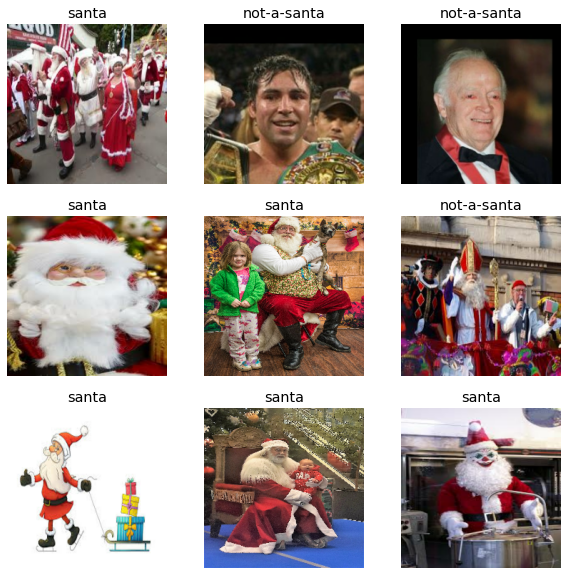

In [77]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

##Configure dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance guide.](https://www.tensorflow.org/guide/data_performance)

In [78]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

##Data Augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. You can learn more about data augmentation in [this](https://www.tensorflow.org/tutorials/images/data_augmentation) tutorial.

In [79]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

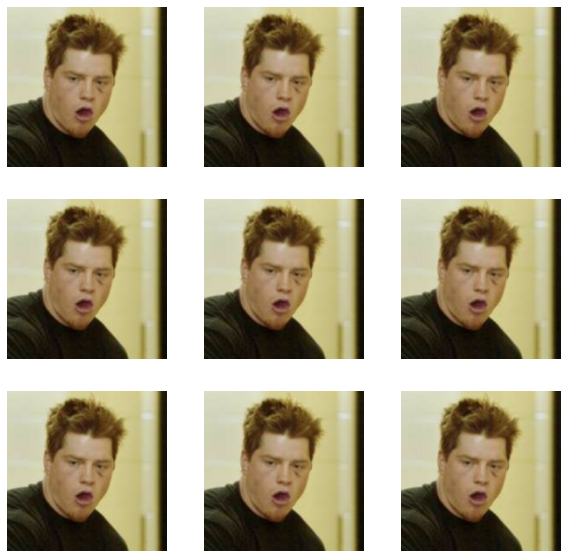

In [80]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

##Create the base model from the pre-trained convnets
You will create the base model from the [VGG16 model](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16). This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of VGG16 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a VGG16 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [81]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [82]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

This feature extractor converts each 224x224x3 image into a 7x7x512 block of features. Let's see what it does to an example batch of images:

In [83]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


##Feature Extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. VGG16 has many layers, so setting the entire model's trainable flag to False will freeze all of them. This is crucial only in case we are using [tf.keras.layers.BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layers in the model.



> Many models contain [tf.keras.layers.BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this notebook.

When you set `layer.trainable = False`, the **BatchNormalization** layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains **BatchNormalization** layers in order to do fine-tuning, you should keep the **BatchNormalization** layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [84]:
model.trainable = False

In [85]:
args = {
  "project_name": "first_transfer_learner_VGG16"
}

In [86]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="larissakelmer",
                 project=args["project_name"], 
                 job_type="Train")

##Add a Classification Head
To generate predictions from the block of features, average over the spatial 7x7 spatial locations, using a [tf.keras.layers.GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer to convert the features to a single 512-element vector per image.

In [87]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


Apply a [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer to convert these features into a single prediction per image.

In [88]:
prediction_layer = tf.keras.layers.Dense(2,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


Build a model by chaining together the data augmentation,[ tf.keras.applications.vgg16.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input), model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` is only redundant because our models not contains a BatchNormalization layer. However, use it here is important for the sake of understanding.

In [89]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [90]:
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(learning_rate=0.001)
#model = AlexNet.build(width=227, height=227, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
history = model.fit(train_dataset, validation_data = validation_dataset,
              batch_size=32, 
              epochs=50, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=True,
                                                   compute_flops=True)]
          )

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] compiling model...
[INFO] training network...


03-12-2022 00:40:17 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
03-12-2022 00:40:18 Assets written to: /content/wandb/run-20221203_003917-qo1dznrg/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221203_003917-qo1dznrg/files/model-best)... Done. 0.4s
03-12-2022 00:41:10 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
03-12-2022 00:41:11 Assets written to: /content/wandb/run-20221203_003917-qo1dznrg/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221203_003917-qo1dznrg/fi

##Compile the model
Compile the model before training it.

In [92]:
# initialize the optimizer and model
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])


In [93]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0   

The 14.714.688 million parameters in VGG16 are frozen, but there are 1,539 thousand trainable parameters in the Dense layer. These are divided between two [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) objects, the weights and biases.

In [94]:
len(model.trainable_variables)

2

##Train and Evalute the model

In [95]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1)

Epoch 1/20
31/31 [==============================] - 16s 387ms/step - loss: 0.0880 - accuracy: 0.9716 - val_loss: 0.0789 - val_accuracy: 0.9792
Epoch 2/20
31/31 [==============================] - 16s 342ms/step - loss: 0.0818 - accuracy: 0.9766 - val_loss: 0.1208 - val_accuracy: 0.9583
Epoch 3/20
31/31 [==============================] - 12s 310ms/step - loss: 0.0911 - accuracy: 0.9655 - val_loss: 0.1329 - val_accuracy: 0.9479
Epoch 4/20
31/31 [==============================] - 12s 312ms/step - loss: 0.1044 - accuracy: 0.9645 - val_loss: 0.0875 - val_accuracy: 0.9688
Epoch 5/20
31/31 [==============================] - 12s 314ms/step - loss: 0.0730 - accuracy: 0.9746 - val_loss: 0.0669 - val_accuracy: 0.9635
Epoch 6/20
31/31 [==============================] - 12s 314ms/step - loss: 0.0769 - accuracy: 0.9746 - val_loss: 0.1154 - val_accuracy: 0.9635
Epoch 7/20
31/31 [==============================] - 12s 311ms/step - loss: 0.1011 - accuracy: 0.9665 - val_loss: 0.0754 - val_accuracy: 0.9844

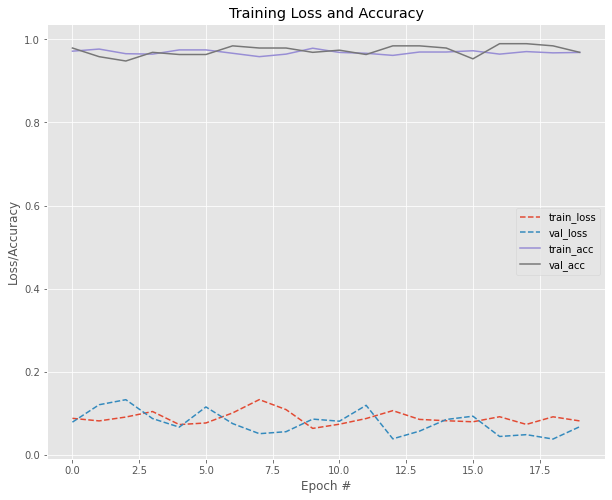

In [96]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

Note the dataset is a generator (`tensorflow.python.data.ops.dataset_ops.PrefetchDataset`). Thus, each time you call the dataset object a new (and different) sequence of images will be returned. This is very important to guarantee the same sequence is used in `model.predict(test_dataset)` and `true_labels`.

In [97]:
type(test_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [98]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y2 = np.concatenate([y for x, y in test_dataset], axis=0)

A possible solution is to extract a snapshot of `test_dataset`.

In [99]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [100]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
1/1 [==============================] - 0s 147ms/step
              precision    recall  f1-score   support

 not-a-santa       1.00      0.94      0.97        16
       santa       0.94      1.00      0.97        16

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



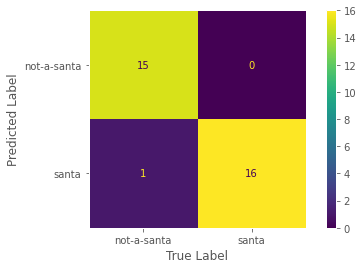

In [101]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [102]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix_test": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

03-12-2022 00:59:12 Uploading figures


In [105]:
# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

03-12-2022 01:02:36 Test Evaluation metrics
03-12-2022 01:02:36 Test Accuracy: 0.96875
03-12-2022 01:02:36 Test Precision: 0.9705882352941176
03-12-2022 01:02:36 Test Recall: 0.96875
03-12-2022 01:02:36 Test F1: 0.9687194525904204


In [106]:
run.finish()

accuracy,▁▅▆▆▇▇▇▇▇▇▇█▇█▇█▇█▇▇████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▇▅▇▇▆▆▇▇▇▇██▇▇▇▇▇▇▇▇▇██▇██▇▇▇▇▇███▇▇
val_loss,█▆▆▅▂▃▂▃▃▄▂▃▂▂▁▁▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▁▁▂▂
Acc,0.96875
CO2_Emissions,0.01455
Count_Params,14715714
Energy_CPU,0.01034
Energy_Consumed,0.02306
Energy_GPU,0.01156


##Fine-Tunning Networks

In the previous section we learned how to treat a pre-trained **Convolutional Neural Network** as **feature extractor**. 

> Using this feature extractor, we forward propagated our dataset of images through the network, extracted the activations at a given layer, and saved the values to disk. A shallow machine
learning classifier was then trained on top of the CNN features.

This CNN feature extractor approach, called **transfer learning**, obtained remarkable accuracy, far higher than any of our previous experiments on the Animals dataset.

But there is another type of transfer learning, one that can actually outperform the feature extraction method if you have sufficient data. This method is called **fine-tuning** and **requires us to perform “network surgery”**. 

1. First, we take a **scalpel and cut off the final set of fully-connected layers** (i.e., the “head” of the network) from a pre-trained /Convolutional Neural Network, such as
VGG, ResNet, Inception, so on. 
2. We then **replace the head** with a new set of fully-connected layers with random initializations. From there all layers below the head are frozen so their weights cannot be
updated (i.e., the backward pass in backpropagation does not reach them)
3.  We then train the network **using a very small learning rate** so the new set of FC layers can start to learn patterns from the previously learned CONV layers earlier in the network. 
4. Optionally, we may unfreeze the rest of the network and continue training. Applying fine-tuning allows us to apply pre-trained networks to recognize classes that they were not originally trained on; furthermore, **this method can lead to higher accuracy than feature extraction**.

In [128]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="larissakelmer",project=args["project_name"], job_type="transferlearning-finetuning")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

KeyError: ignored

## 3.1 Transfer Learning and Fine-tuning

**Fine-tuning is a type of transfer learning**. We apply fine-tuning to deep learning models that have already been trained on a given dataset. Typically, these networks are state-of-the-art architectures
such as VGG, ResNet, and Inception that have been trained on the ImageNet dataset.

As we found out in previous section on feature extraction, these networks contain rich, discriminative filters that can be used on datasets and class labels outside the ones they have already been trained on. However, instead of simply applying feature extraction, we are going to perform network surgery and modify the actual architecture so we can re-train parts of the network.


If this sounds like something out of a bad horror movie; don’t worry, there won’t be any blood and gore – but we will have some fun and learn a lot with our experiments. To understand how finetuning
works, consider Figure below (left) where we have the layers of the VGG16 network. As we know, the final set of layers (i.e., the “head”) are our fully-connected layers along with our softmax classifier. When performing fine-tuning, we actually remove the head from the network, just as in feature extraction (middle). However, unlike feature extraction, when we perform fine-tuning we actually **build a new fully-connected head and place it on top of the original architecture
(right)**.


<center><img width="600" src="https://drive.google.com/uc?export=view&id=1qTj4KeosAyDUcffqTQ_BepiINEUXs-cE"></center><center><b>Left</b>:  The original VGG16 network architecture. <b>Middle</b>: Removing the FC layers from VGG16 and treating the final POOL layer as a feature extractor. <b>Right</b>: Removing the original FC layers and replacing them with a brand new FC head. These new FC layers can then be fine-tuned to the specific dataset (the old FC layers are no longer used).</center>


In most cases your new FC head will have fewer parameters than the original one; however, that really depends on your particular dataset. The new FC head is randomly initialized (just like any other layer in a new network) and connected to the body of the original network, and we are ready to train.

However, there is a problem – our CONV layers have already learned rich, discriminating filters while our FC layers are brand new and totally random. If we allow the gradient to backpropagate from these random values all the way through the body of our network, we risk destroying these powerful features. To circumvent this, we instead let our FC head “warm up” by (ironically) “freezing” all layers in the body of the network as
in Figure below (left).



<center><img width="600" src="https://drive.google.com/uc?export=view&id=11Zh6mGG3qMISsnCg6JLgL-sH7TnxpUSC"></center><center><b>Left</b>: When we start the fine-tuning process we freeze all CONV layers in the network and only allow the gradient to backpropagate through the FC layers. Doing this allows our network to “warm up”. <b>Right</b>: After the FC layers have had a chance to warm up we may choose to unfreeze all layers in the network and allow each of them to be fine-tuned as well.</center>


Training data is forward propagated through the network as we normally would; however, the backpropagation is stopped after the FC layers, which allows these layers to start to learn patterns from the highly discriminative CONV layers. In some cases, we may never unfreeze the body of the network as our new FC head may obtain sufficient accuracy. 

However, for some datasets it is often advantageous to allow the original CONV layers to be modified during the fine-tuning process as
well (Figure above, right).

After the FC head has started to learn patterns in our dataset, pause training, unfreeze the body, and then continue the training, but with a very **small learning rate** – we do not want to deviate our
CONV filters dramatically. 

Training is then allowed to continue until sufficient accuracy is obtained. Fine-tuning is a super powerful method to obtain image classifiers from pre-trained CNNs on custom datasets, even more powerful than feature extraction in most cases. **The downside is that
fine-tuning can require a bit more work and your choice in FC head parameters does play a big part
in network accuracy** – you can’t rely strictly on regularization techniques here as your network has already been pre-trained and you can’t deviate from the regularization already being performed by
the network.

Secondly, for small datasets, it can be challenging to get your network to start “learning” from a “cold” FC start, which is why we freeze the body of the network first. Even still, getting past the warm-up stage can be a bit of a challenge and might require you to use optimizers other than SGD. **While fine-tuning does require a bit more effort, if it is done correctly, you’ll nearly always enjoy higher accuracy**.

## 3.2 Indexes and Layers

Prior to performing **network surgery**, we need to know the **layer name and index** of every layer in a given deep learning model. We need this information as we’ll be required to **“freeze”** and **“unfreeze”** certain layers in a pre-trained CNN.

Without knowing the layer names and indexes ahead of time, we would be “cutting blindly”, an out-of-control surgeon with no game plan. **If we instead take a few minutes to examine the network architecture and implementation, we can better prepare for our surgery.**

In [129]:
# import the necessary packages
from tensorflow.keras.applications import VGG16

# whether or not to include top of CNN
include_top = 0

# load the VGG16 network
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [130]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

Again, this fully-connected head is very simplistic compared to the original head from VGG16 which consists of two sets of 4,096 FC layers. However, for most fine-tuning problems you are not seeking to replicate the original head of the network, but rather simplify it so it is easier to fine-tune– the fewer parameters in the head, the more likely we’ll be to correctly tune the network to a new
classification task.


In some cases you’ll want to allow the entire body to be trainable; however, **for deeper architectures with many parameters such as VGG, I suggest only unfreezing the top CONV layers and then continuing training**. If classification accuracy continues to improve (without overfitting), you may want to consider unfreezing more layers in the body.

In the previous section we learned how to treat a pre-trained **Convolutional Neural Network** as **feature extractor**. 

> Using this feature extractor, we forward propagated our dataset of images through the network, extracted the activations at a given layer, and saved the values to disk. A shallow machine
learning classifier was then trained on top of the CNN features.

This CNN feature extractor approach, called **transfer learning**, obtained remarkable accuracy, far higher than any of our previous experiments on the Animals dataset.

But there is another type of transfer learning, one that can actually outperform the feature extraction method if you have sufficient data. This method is called **fine-tuning** and **requires us to perform “network surgery”**. 

1. First, we take a **scalpel and cut off the final set of fully-connected layers** (i.e., the “head” of the network) from a pre-trained /Convolutional Neural Network, such as
VGG, ResNet, Inception, so on. 
2. We then **replace the head** with a new set of fully-connected layers with random initializations. From there all layers below the head are frozen so their weights cannot be
updated (i.e., the backward pass in backpropagation does not reach them)
3.  We then train the network **using a very small learning rate** so the new set of FC layers can start to learn patterns from the previously learned CONV layers earlier in the network. 
4. Optionally, we may unfreeze the rest of the network and continue training. Applying fine-tuning allows us to apply pre-trained networks to recognize classes that they were not originally trained on; furthermore, **this method can lead to higher accuracy than feature extraction**.

## 3.1 Transfer Learning and Fine-tuning

**Fine-tuning is a type of transfer learning**. We apply fine-tuning to deep learning models that have already been trained on a given dataset. Typically, these networks are state-of-the-art architectures
such as VGG, ResNet, and Inception that have been trained on the ImageNet dataset.

As we found out in previous section on feature extraction, these networks contain rich, discriminative filters that can be used on datasets and class labels outside the ones they have already been trained on. However, instead of simply applying feature extraction, we are going to perform network surgery and modify the actual architecture so we can re-train parts of the network.


If this sounds like something out of a bad horror movie; don’t worry, there won’t be any blood and gore – but we will have some fun and learn a lot with our experiments. To understand how finetuning
works, consider Figure below (left) where we have the layers of the VGG16 network. As we know, the final set of layers (i.e., the “head”) are our fully-connected layers along with our softmax classifier. When performing fine-tuning, we actually remove the head from the network, just as in feature extraction (middle). However, unlike feature extraction, when we perform fine-tuning we actually **build a new fully-connected head and place it on top of the original architecture
(right)**.


<center><img width="600" src="https://drive.google.com/uc?export=view&id=1qTj4KeosAyDUcffqTQ_BepiINEUXs-cE"></center><center><b>Left</b>:  The original VGG16 network architecture. <b>Middle</b>: Removing the FC layers from VGG16 and treating the final POOL layer as a feature extractor. <b>Right</b>: Removing the original FC layers and replacing them with a brand new FC head. These new FC layers can then be fine-tuned to the specific dataset (the old FC layers are no longer used).</center>


In most cases your new FC head will have fewer parameters than the original one; however, that really depends on your particular dataset. The new FC head is randomly initialized (just like any other layer in a new network) and connected to the body of the original network, and we are ready to train.

However, there is a problem – our CONV layers have already learned rich, discriminating filters while our FC layers are brand new and totally random. If we allow the gradient to backpropagate from these random values all the way through the body of our network, we risk destroying these powerful features. To circumvent this, we instead let our FC head “warm up” by (ironically) “freezing” all layers in the body of the network as
in Figure below (left).



<center><img width="600" src="https://drive.google.com/uc?export=view&id=11Zh6mGG3qMISsnCg6JLgL-sH7TnxpUSC"></center><center><b>Left</b>: When we start the fine-tuning process we freeze all CONV layers in the network and only allow the gradient to backpropagate through the FC layers. Doing this allows our network to “warm up”. <b>Right</b>: After the FC layers have had a chance to warm up we may choose to unfreeze all layers in the network and allow each of them to be fine-tuned as well.</center>


Training data is forward propagated through the network as we normally would; however, the backpropagation is stopped after the FC layers, which allows these layers to start to learn patterns from the highly discriminative CONV layers. In some cases, we may never unfreeze the body of the network as our new FC head may obtain sufficient accuracy. 

However, for some datasets it is often advantageous to allow the original CONV layers to be modified during the fine-tuning process as
well (Figure above, right).

After the FC head has started to learn patterns in our dataset, pause training, unfreeze the body, and then continue the training, but with a very **small learning rate** – we do not want to deviate our
CONV filters dramatically. 

Training is then allowed to continue until sufficient accuracy is obtained. Fine-tuning is a super powerful method to obtain image classifiers from pre-trained CNNs on custom datasets, even more powerful than feature extraction in most cases. **The downside is that
fine-tuning can require a bit more work and your choice in FC head parameters does play a big part
in network accuracy** – you can’t rely strictly on regularization techniques here as your network has already been pre-trained and you can’t deviate from the regularization already being performed by
the network.

Secondly, for small datasets, it can be challenging to get your network to start “learning” from a “cold” FC start, which is why we freeze the body of the network first. Even still, getting past the warm-up stage can be a bit of a challenge and might require you to use optimizers other than SGD. **While fine-tuning does require a bit more effort, if it is done correctly, you’ll nearly always enjoy higher accuracy**.

## 3.2 Indexes and Layers

Prior to performing **network surgery**, we need to know the **layer name and index** of every layer in a given deep learning model. We need this information as we’ll be required to **“freeze”** and **“unfreeze”** certain layers in a pre-trained CNN.

Without knowing the layer names and indexes ahead of time, we would be “cutting blindly”, an out-of-control surgeon with no game plan. **If we instead take a few minutes to examine the network architecture and implementation, we can better prepare for our surgery.**

In [131]:
# import the necessary packages
from tensorflow.keras.applications import xception

# whether or not to include top of CNN
include_top = 0

# load the VGG16 network
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [132]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

Again, this fully-connected head is very simplistic compared to the original head from VGG16 which consists of two sets of 4,096 FC layers. However, for most fine-tuning problems you are not seeking to replicate the original head of the network, but rather simplify it so it is easier to fine-tune– the fewer parameters in the head, the more likely we’ll be to correctly tune the network to a new
classification task.


In some cases you’ll want to allow the entire body to be trainable; however, **for deeper architectures with many parameters such as VGG, I suggest only unfreezing the top CONV layers and then continuing training**. If classification accuracy continues to improve (without overfitting), you may want to consider unfreezing more layers in the body.

## 3.3 All in one

### First Stage

In [133]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [134]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [135]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [136]:
base_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-t

In [137]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [138]:
# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=base_model.input, outputs=headModel)

In [139]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [140]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [141]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in model.layers[4].layers:
	layer.trainable = False

In [142]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [143]:
# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [145]:
# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=3,
                    verbose=1)

[INFO] training head...
Epoch 1/3
31/31 [==============================] - 15s 330ms/step - loss: 3.3828 - accuracy: 0.8426 - val_loss: 1.1786 - val_accuracy: 0.9375
Epoch 2/3
31/31 [==============================] - 13s 319ms/step - loss: 1.0382 - accuracy: 0.9208 - val_loss: 1.1219 - val_accuracy: 0.9219
Epoch 3/3
31/31 [==============================] - 13s 316ms/step - loss: 0.8262 - accuracy: 0.9310 - val_loss: 0.4338 - val_accuracy: 0.9688


In [146]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(learning_rate=0.001)
#model = AlexNet.build(width=227, height=227, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the network
print("[INFO] training network...")
history = model.fit(train_dataset, validation_data = validation_dataset,
              batch_size=32, 
              epochs=20, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=True,
                                                   compute_flops=True)]
          )

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] compiling model...
[INFO] training network...


03-12-2022 01:27:39 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
03-12-2022 01:27:40 Assets written to: /content/wandb/run-20221203_012611-185uv6qc/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221203_012611-185uv6qc/files/model-best)... Done. 0.9s
03-12-2022 01:27:58 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
03-12-2022 01:27:59 Assets written to: /content/wandb/run-20221203_012611-185uv6qc/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221203_012611-185uv6qc/fi

### Second Stage

In [147]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [148]:
# loop over the layers in the base model network and display them to the
# console
for (i, layer) in enumerate(model.layers[4].layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [149]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [150]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in model.layers[4].layers[15:]:
	layer.trainable = True

In [151]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [152]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

[INFO] re-compiling model...


In [163]:
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

[INFO] training head...
Epoch 1/10
31/31 [==============================] - 14s 325ms/step - loss: 0.0438 - accuracy: 0.9898 - val_loss: 0.0048 - val_accuracy: 0.9948
Epoch 2/10
31/31 [==============================] - 13s 327ms/step - loss: 0.0353 - accuracy: 0.9878 - val_loss: 9.1265e-05 - val_accuracy: 1.0000
Epoch 3/10
31/31 [==============================] - 13s 328ms/step - loss: 0.0444 - accuracy: 0.9848 - val_loss: 0.0047 - val_accuracy: 0.9948
Epoch 4/10
31/31 [==============================] - 13s 325ms/step - loss: 0.0222 - accuracy: 0.9909 - val_loss: 1.0612e-04 - val_accuracy: 1.0000
Epoch 5/10
31/31 [==============================] - 13s 327ms/step - loss: 0.0225 - accuracy: 0.9919 - val_loss: 2.3463e-04 - val_accuracy: 1.0000
Epoch 6/10
31/31 [==============================] - 13s 324ms/step - loss: 0.0398 - accuracy: 0.9878 - val_loss: 1.7621e-04 - val_accuracy: 1.0000
Epoch 7/10
31/31 [==============================] - 13s 328ms/step - loss: 0.0273 - accuracy: 0.9919 -

Additional accuracy can be obtained by performing more aggressive data augmentation and continually unfreezing more and more CONV blocks in VGG16. While fine-tuning is certainly more work than feature extraction, it also enables us to tune and modify the weights in our CNN to a particular dataset – something that feature extraction does not allow. Thus, when given enough training data, consider applying fine-tuning as you’ll likely obtain higher classification accuracy
than simple feature extraction alone.

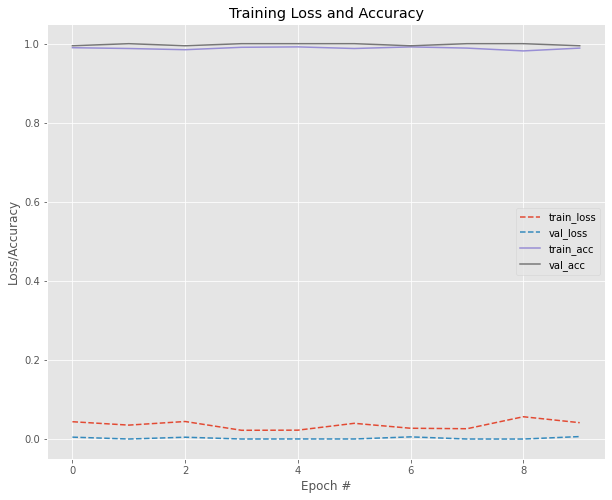

In [164]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 10), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [165]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [166]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
1/1 [==============================] - 0s 29ms/step
              precision    recall  f1-score   support

 not-a-santa       1.00      0.93      0.96        14
       santa       0.95      1.00      0.97        18

    accuracy                           0.97        32
   macro avg       0.97      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32



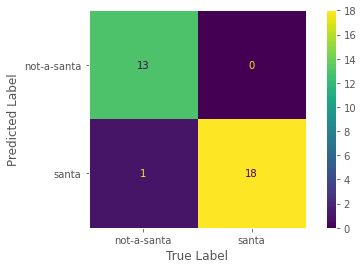

In [167]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [168]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix_test": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)


03-12-2022 01:42:18 Uploading figures


In [169]:
# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()


03-12-2022 01:42:19 Test Evaluation metrics
03-12-2022 01:42:19 Test Accuracy: 0.96875
03-12-2022 01:42:19 Test Precision: 0.9703947368421052
03-12-2022 01:42:19 Test Recall: 0.96875
03-12-2022 01:42:19 Test F1: 0.9685935935935936
